In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl import simulate
from tf_rl.models import MLP

from __future__ import print_function

In [26]:
from tf_rl.simulation.manipulation import GameObject, HeroSimulation, objects_colliding

In [27]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmpp9se1w4p


In [202]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from collections import defaultdict
from euclid import Circle, Point2, Vector2, LineSegment2
from itertools import combinations

import tf_rl.utils.svg as svg

class Manipulation(HeroSimulation):
    def __init__(self, settings, task):
        super(Manipulation, self).__init__(settings)
        self.actions = [Vector2(*a) for a in self.settings["action_acc"]]
        self.num_actions = len(self.actions)
        self.task = task
        
        self.npc = {}
        def add_obj(typ):
            obj = GameObject(Point2(0, 0), Vector2(0,0), typ, mass=2.0, radius=self.settings['obj_radius'])
            self.randomize_position(obj, margin=2 * self.settings['obj_radius']) 
            self.add(obj)
            self.npc[typ] = obj
        
        add_obj("red")
        add_obj("blue")
        add_obj("green")
        add_obj("orange")
        
        self.randomize_position(self.hero)
        
        self.prev_distance = self.distance_to_minimize()
        self.prev_reward   = 0.0
        
        self.task.preprocessing(self)
        
    def observe(self):
        obs = super(Manipulation, self).observe()
        nlp = self.task.description(self)
        return (obs, nlp)
        
    def distance_to_minimize(self):
        return self.task.distance_to_minimize(self)
    
    def description(self):
        self.task.description(self)

    def randomize_position(self, obj, noncoliding=True, margin=0.0):
        gen = lambda: random.uniform(obj.radius + margin, 1.0 - obj.radius - margin)
        obj.position = Point2(gen(), gen())
                
        while noncoliding and any(objects_colliding(obj, other) for other in self.objects if other is not obj):
            obj.position = Point2(gen(), gen())
                                         
    def perform_action(self, action):
        self.hero.speed += self.actions[action]

    def collect_reward(self):
        new_distance = self.distance_to_minimize()
        delta = self.prev_distance - new_distance 
        self.prev_distance = new_distance
        self.prev_reward = 100.0 * delta
        return self.prev_reward
    
    def success(self):
        return self.task.success(self)
    
    def to_html(self, stats=[]):
        stats = stats[:]
        stats.extend([
            "reward = %.3f" % (self.prev_reward),
            "mission = %s" % (' '.join(self.task.description_text(self)),)
        ])
        return super(Manipulation, self).to_html(stats=stats)        

In [203]:
SETTINGS = {
    'size': 500,
    'colors': {
        'hero': 'yellow',
        'red':  'red',
        'blue': 'blue',
        'green': 'green',
        'orange': 'orange',
    },
    'restitution': 0.6,
    'observable_distance': 1.5,
    'num_observation_lines': 32,
    'observable_objects': [
        'red',
        'blue',
        'green',
        'orange',
        'wall',
    ],
    'action_acc': [
        [0.0,   0.0],    # stay still
        [-0.1, 0.0],    # left
        [0.1,  0.0],    # right
        [0.0,   -0.1],  # up
        [0.0,   0.1],   # down
    ],
    'obj_radius': 0.045,
    'viscosity': 0.97,
}

In [204]:
class NLPAndStateDeepQ(DiscreteDeepQ):
    def create_observation_variable(self, name):
        obs_var = tf.placeholder(tf.float32, [None,] + self.observation_size, name=name+"_obs")
        nlp_var   = tf.placeholder(tf.int32, (SEQ_LEN, None), name=name+"_nlp")
        return (obs_var, nlp_var)
        
    def prepare_observation(self, observation):
        obs, nlp = observation
        obs = obs[np.newaxis,:]
        nlp = nlp[:, np.newaxis]
        return (obs, nlp)

    def batch_samples(self, samples):
        # batch states
        nlp_states         = np.empty([SEQ_LEN, len(samples)], dtype=np.int32)
        nlp_newstates      = np.empty([SEQ_LEN, len(samples)], dtype=np.int32)
        obs_states         = np.empty([len(samples)] + self.observation_size, dtype=np.float32)
        obs_newstates      = np.empty([len(samples)] + self.observation_size, dtype=np.float32)
        
        action_mask    = np.zeros((len(samples), self.num_actions))

        newstates_mask = np.empty((len(samples),))
        rewards        = np.empty((len(samples),))

        for i, (state, action, reward, newstate) in enumerate(samples):
            obs_state,    nlp_state    = state
            nlp_states[:, i] = nlp_state
            obs_states[i, :] = obs_state
            action_mask[i] = 0
            action_mask[i][action] = 1
            rewards[i] = reward
            if newstate is not None:
                obs_newstate, nlp_newstate = newstate
                nlp_newstates[:, i] = nlp_newstate
                obs_newstates[i, :] = obs_newstate
                newstates_mask[i] = 1
            else:
                nlp_newstate[:, i] = 0
                newstates_mask[i] = 0
                
        states    = (obs_states,    nlp_states)
        newstates = (obs_newstates, nlp_newstates)

        return states, action_mask, rewards, newstates, newstates_mask

In [205]:
class Task(object):        
    def description_text(self, sim):
        raise NotImplementedError()
        
    def description(self, sim):
        return encode_sentence(pad_sentence(self.description_text(sim)))
    
    def success(self, sim):
        return self.distance_to_minimize(sim) < 0.1
        
    def distance_to_minimize(self, sim):
        raise NotImplementedError()
        
    def preprocessing(self, sim):
        pass

In [219]:
EOS = "**EOS**"
DICTIONARY = ['go', 'left', 'right','top', 'bottom', 'corner', 'move', 'to',
              "arrive", "at", "find", "locate", "promptly", "now",
              EOS]

SEQ_LEN = 7
EMBEDDING_SIZE = 10
LSTM_HIDDENS = [30, 30]
OBS_HIDDENS  = [100, 30]
HL_HIDDENS   = [50,]

assert LSTM_HIDDENS[-1] == OBS_HIDDENS[-1] # equal attribution

NSYMBOLS = len(DICTIONARY)

def pad_sentence(sentence):
    sentence = list(sentence[:])
    while len(sentence) < SEQ_LEN:
        sentence.append(EOS)
    return sentence

def encode_sentence(sentence):
    return np.array([DICTIONARY.index(w) for w in sentence], dtype=np.int32)

In [220]:
class MoveTask(Task):
    def __init__(self):
        self.target_name, self.target_position = random.choice([
            (["top",    "left",  "corner"], Point2(0,0)),
            (["top",    "right", "corner"], Point2(1,0)),
            (["bottom", "left",  "corner"], Point2(0,1)),
            (["bottom", "right", "corner"], Point2(1,1))
        ])
        self.prefix = random.choice([
            ["move", "to"],
            ["arrive", "at"],
            ["find"],
            ["locate"],
        ])
        self.suffix = random.choice([
            ["promptly",],
            ["now",],
            [],
        ])
        self.mission = self.prefix + self.target_name + self.suffix
        assert len(self.mission) + 1 <= SEQ_LEN
        
    def description_text(self, sim):
        return self.mission
    
    def distance_to_minimize(self, sim):
        return sim.hero.position.distance(self.target_position)

                
g = Manipulation(SETTINGS, MoveTask())

In [221]:
from tf_rl.models import NLPLSTM

# def __init__(self, embedding_size, nsymbols, lstm_hiddens, scope="NLPLSTM", initialize=True):
       
    
class NlpAndState(object):
    def __init__(self, scope="nlp_and_state", initialize=True):
        self.scope = scope
        self.lstm, self.obs_mlp, self.hl_mlp = None, None, None
        if initialize:
            with tf.variable_scope(scope):
                self.lstm    = NLPLSTM(EMBEDDING_SIZE, NSYMBOLS, LSTM_HIDDENS, scope="nlp_lstm")
                self.obs_mlp = MLP([g.observation_size,], OBS_HIDDENS, [tf.tanh] * len(OBS_HIDDENS), scope="obs_mlp")
                self.hl_mlp  = MLP([OBS_HIDDENS[-1], LSTM_HIDDENS[-1]], HL_HIDDENS + [g.num_actions], 
                                   [tf.tanh] * len(HL_HIDDENS)+ [tf.identity], scope='hl_mlp')
        
    def variables(self):
        return self.lstm.variables() + self.obs_mlp.variables() + self.hl_mlp.variables()
    
    def __call__(self, observation):
        with tf.variable_scope(self.scope):
            obs, nlp = observation
            obs_out = self.obs_mlp(obs)
            nlp_outputs, _ = self.lstm(nlp)
            nlp_out = nlp_outputs[-1][-1]
            
            return self.hl_mlp([obs_out, nlp_out])
    
    def copy(self, scope=None):
        scope = scope or self.scope + "_copy"
        with tf.variable_scope(scope):
            n = NlpAndState(scope=scope, initialize=False)
            n.lstm    = self.lstm.copy()
            n.obs_mlp = self.obs_mlp.copy()
            n.hl_mlp  = self.hl_mlp.copy()
            return n
        

In [222]:
# Tensorflow business - it is always good to reset a graph before creating a new controller.
tf.ops.reset_default_graph()
if 'session' in globals(): session.close()
session = tf.InteractiveSession()

# This little guy will let us run tensorboard
#      tensorboard --logdir [LOG_DIR]
journalist = tf.train.SummaryWriter(LOG_DIR)

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden
# layers
brain = NlpAndState()

# The optimizer to use. Here we use RMSProp as recommended
# by the publication
optimizer = tf.train.AdamOptimizer(learning_rate= 0.001, beta1=0.5)

#     optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

# DiscreteDeepQ object
current_controller = NLPAndStateDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,
                                      discount_rate=0.99, exploration_period=5000, max_experience=20000, 
                                      store_every_nth=2, train_every_nth=2,
                                      target_network_update_rate=0.0001,
                                      summary_writer=journalist)

session.run(tf.initialize_all_variables())
session.run(current_controller.target_network_update)
# graph was not available when journalist was created  
journalist.add_graph(session.graph_def)

In [223]:
results = []

In [226]:
FPS          = 30
ACTION_EVERY = 3
SIM_TIME     = 5
    
fast_mode = True
training  = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 100
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    while True:
        g = Manipulation(SETTINGS, MoveTask())
        simulate(simulation=g,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 training=training,
                 max_frames=SIM_TIME * FPS,
                 save_path=None)
        results.append(1 if g.success() else 0)
except KeyboardInterrupt:
    print("Interrupted")

Interrupted


[ 0.42915464  1.15334117]


(0.0, 1.0)

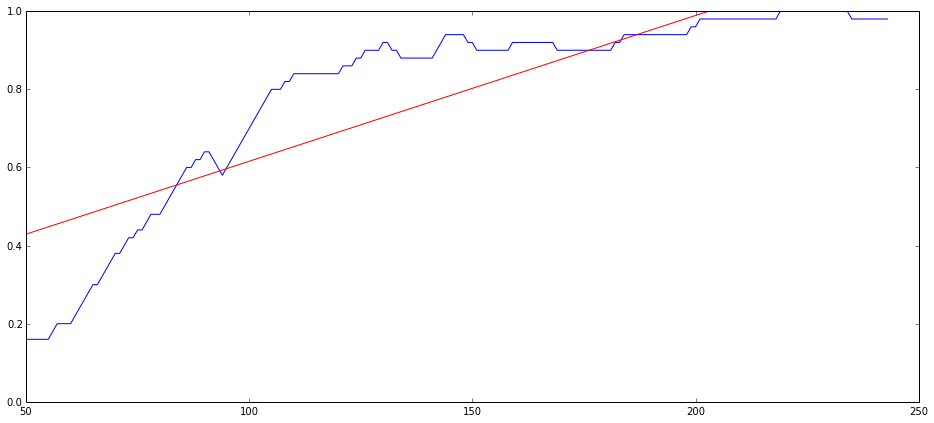

In [227]:
SMOOTHING=50
x = range(SMOOTHING, len(results))
y = [sum(results[i-SMOOTHING:i]) / SMOOTHING for i in x]
f = plt.figure(figsize=(16,7))
plt.plot(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
print(p([SMOOTHING, len(results)]))
plt.plot(x,p(x),color="red")
plt.gca().set_ylim([0.0, 1.0])

In [228]:
saved_plots.append((x, y, "verbal diversity"))

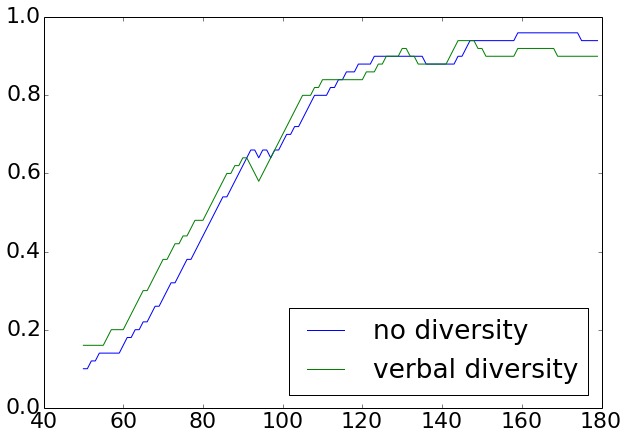

In [238]:
f = plt.figure(figsize=(10,7))

matplotlib.rcParams.update({'font.size': 22})

for x, y, name in saved_plots:
    plt.plot(x[:130],y[:130],label=name)

plt.ylim([0.,1.])
plt.legend(loc="lower right")

In [216]:
saved_plots = []

In [213]:
import time
from IPython.display import display, clear_output

try:
    while True:
        g.step(0.03)
        time.sleep(0.03)
        clear_output(wait=True)
        display(g.to_html())
except KeyboardInterrupt:
    print('Interrupted')

Interrupted


8

In [383]:
np.get_printoptions()

{'edgeitems': 3,
 'formatter': None,
 'infstr': 'inf',
 'linewidth': 75,
 'nanstr': 'nan',
 'precision': 8,
 'suppress': False,
 'threshold': 1000}

In [386]:
np.set_printoptions(formatter={'float_kind':lambda x: '%.2f\t' % (x,)})
# g.__class__ = HeroSimulation
print(g.observe().reshape(SETTINGS["num_observation_lines"], len(SETTINGS["observable_objects"]) + 4))
np.set_printoptions(formatter=None)
g.to_html()


[[1.00	 1.00	 0.23	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.23	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.20	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.14	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.11	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.09	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.08	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.09	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.11	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.14	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.20	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.39	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.44	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.45	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.48	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 0.19	 1.00	 -0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.63	 0.00	 0.00	 -0.02	 0.03	]
 [1.00	 1.00	 0.71	 0.00	 0.00	 -

In [361]:
SETTINGS["num_observation_lines"], len(SETTINGS["observable_objects"]) + 4

(32, 6)

In [362]:
m.observe().shape

(16, 6)